# 4.b - Machine Learning : régression

## Objectif

Dans ce notebook, on se propose d'essayer plusieurs méthodes de regression, sans fine-tuning, afin de se faire une idée de quels algorithmes performent mieux que les autres.
Dans l'ordre, voici les modèles explorés :

1. <span style="position:center; top:10px; right:5px; width:100px; height:90px; margin:10px;">[Modèle_linéaire](#Modèle-linéaire)</span>
2. <span style="position:center; top:10px; right:5px; width:100px; height:90px; margin:10px;">[Nearest_neighbours](#Nearest-neighbours)</span>
3. <span style="position:center; top:10px; right:5px; width:100px; height:90px; margin:10px;">[Decision_tree](#Decision-tree)</span>
4. <span style="position:center; top:10px; right:5px; width:100px; height:90px; margin:10px;">[Random_forest](#Random-forest)</span>
5. <span style="position:center; top:10px; right:5px; width:100px; height:90px; margin:10px;">[Gradient_boosting](#Gradient-boosting)</span>

Nous laisserons tous les paramètres de définition des algorithmes par défaut. Le prochain notebook aura pour objectif de fine tuner un seul des algorithmes explorés ici, afin de produire le meilleur modèle possible.

<img src="http://www.psdgraphics.com/wp-content/uploads/2009/12/warning-sign.jpg" alt="NYC_map" align="left" style="width:30px;height:20px;">
ATTENTION : Nous vous conseillons de ne pas lancer un 'run all' sur ce notebook ! Certaines commandes (calculs de learning curve) sont très longues ! Il est préférable de lancer les cellules au fur et à mesure, celles qu'il vaut mieux ne pas lancer seront indiquées.

In [5]:
%matplotlib inline

## Import et préparation du dataset
Importons les librairies que nous utiliserons :

In [6]:
import os
#os.chdir('/Users/pierredesmet/Documents/Documents Word/Etudes/UTT/ENSAE/Python pour le Data Scientist')
os.chdir('C:\\Users\\Alexis\\Google Drive\\Documents\\ENSAE\\Semestre 1\\Projet python\\')
import pandas
import matplotlib.pyplot as plt
import importation
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
import numpy
import seaborn

Chargons les données en mémoire : 

In [7]:
trips = importation.chargement_donnees()
trips = importation.clean(trips)

D'après le notebook 3, on a vu que:
- l'application de paiement (`vendor_id`) ne joue aucun role -> on la supprime
- que la valeur des pourboires n'est pas renseignée lorsque le paiement s'est effectué en espèces -> on ne conserve donc que le mode de paiment par carte bleue 
- concernant la date/heure, on ne conserve que l'information jour/nuit, lundi/mardi/etc.
- la variable `vitesse_moyenne` = `trip_distance`/`trip_time_in_secs` est très importante. On la construit, puis on supprime les deux autres.

De plus, on supprime les variables suivantes :
- `medallion` : à priori, le medallion est attribué aléatoirement à chaque début de service
- `hack_license` : bien que certains chauffeurs soient sans doute plus 'agréable' que d'autres, et donc peuvent avoir plus de pourboires, on ne va pas prendre en compte cette variable pour deux raisons : 1) cela ferait trop de variables (environ 38 000 !) et 2) on cherche à créer un algorithme qui prédit pour une valeur de pourboire pour tout taximen qui voit la course s'afficher sur son écran
- `total_amount` : en effet, avant le début de la course, on ne connait pas encore les surcharges, les éventuels péages, etc., et surtout on sait que la somme de variables de prix (`tip_amount` inclu), vaut `total_amount` ! C'est à dire que donner toutes les variables sauf `tip_amount` revient à la donner car elle vaut `total_amount` - `fare_amount` - `surcharge` - `tolls_amount` - ...

In [8]:
trips['tip_amount'].loc[trips['payment_type'] == 'CSH'].describe()

count    333760.000000
mean          0.000193
std           0.031905
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.950000
Name: tip_amount, dtype: float64

In [9]:
trips['vitesse_moyenne'] = trips['trip_distance']/trips['trip_time_in_secs']
trips = trips.drop(['trip_distance', 'trip_time_in_secs', 'medallion', 'hack_license', 'vendor_id', 
            'pickup_datetime', 'dropoff_datetime', 'total_amount'], axis=1)
trips = trips[(trips['payment_type'] == 'CRD')]
trips = trips.drop(['payment_type'], axis=1)

In [10]:
trips.head()

,fare_amount,surcharge,tip_amount,tolls_amount,passenger_count,pickup_longitude,pickup_lattitude,dropoff_longitude,dropoff_lattitude,nuit_jour,jour_semaine,vitesse_moyenne
1,5.0,0.0,1.0,0.0,1,-73.999786,40.728497,-73.994179,40.724926,jour,Sunday,0.002375
12,10.0,0.0,2.0,0.0,1,-73.986336,40.739922,-73.975296,40.765106,jour,Sunday,0.004481
13,7.5,0.0,1.5,0.0,6,-73.999367,40.733875,-73.981468,40.753502,jour,Sunday,0.006733
14,12.5,0.0,1.5,0.0,1,-73.966362,40.794418,-73.989075,40.752293,jour,Sunday,0.005000
18,22.0,0.5,4.5,0.0,6,-73.998283,40.715694,-73.936600,40.752804,nuit,Sunday,0.007604


Enfin, et comme dans le notebook 3, nous allons transformer les variables qualitatives `nuit_jour` et `jour_semaine` en dummy variables :

In [11]:
trips = pandas.get_dummies(data=trips, columns=['nuit_jour', 'jour_semaine'])  

In [12]:
trips.head()

,fare_amount,surcharge,tip_amount,tolls_amount,passenger_count,pickup_longitude,pickup_lattitude,dropoff_longitude,dropoff_lattitude,vitesse_moyenne,nuit_jour_jour,nuit_jour_nuit,jour_semaine_Friday,jour_semaine_Monday,jour_semaine_Saturday,jour_semaine_Sunday,jour_semaine_Thursday,jour_semaine_Tuesday,jour_semaine_Wednesday
1,5.0,0.0,1.0,0.0,1,-73.999786,40.728497,-73.994179,40.724926,0.002375,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12,10.0,0.0,2.0,0.0,1,-73.986336,40.739922,-73.975296,40.765106,0.004481,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13,7.5,0.0,1.5,0.0,6,-73.999367,40.733875,-73.981468,40.753502,0.006733,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14,12.5,0.0,1.5,0.0,1,-73.966362,40.794418,-73.989075,40.752293,0.005000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18,22.0,0.5,4.5,0.0,6,-73.998283,40.715694,-73.936600,40.752804,0.007604,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Nous obtenons ce dataset final avec lequel nous travaillerons désormais. 

## Test de plusieurs modèles

### Modèle linéaire
Commençons par la méthode la plus simple : le modèle linéaire.
Créeons 'X' et 'y', les variables explicatives et la variable prédite.

In [13]:
X = trips.drop(['tip_amount','nuit_jour_jour', 'jour_semaine_Monday'], axis=1) # on supprime juste les deux dummy variable 'trap'
y = trips['tip_amount']

In [14]:
X.head()

,fare_amount,surcharge,tolls_amount,passenger_count,pickup_longitude,pickup_lattitude,dropoff_longitude,dropoff_lattitude,vitesse_moyenne,nuit_jour_nuit,jour_semaine_Friday,jour_semaine_Saturday,jour_semaine_Sunday,jour_semaine_Thursday,jour_semaine_Tuesday,jour_semaine_Wednesday
1,5.0,0.0,0.0,1,-73.999786,40.728497,-73.994179,40.724926,0.002375,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12,10.0,0.0,0.0,1,-73.986336,40.739922,-73.975296,40.765106,0.004481,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13,7.5,0.0,0.0,6,-73.999367,40.733875,-73.981468,40.753502,0.006733,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14,12.5,0.0,0.0,1,-73.966362,40.794418,-73.989075,40.752293,0.005000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18,22.0,0.5,0.0,6,-73.998283,40.715694,-73.936600,40.752804,0.007604,1.0,0.0,0.0,1.0,0.0,0.0,0.0


Splittons notre jeu de données en deux parties : une pour l'apprentissage, une autre pour la validation.

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

Puis effectuons la régression linéaire :

In [17]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))

0.559267517533
0.577013643865


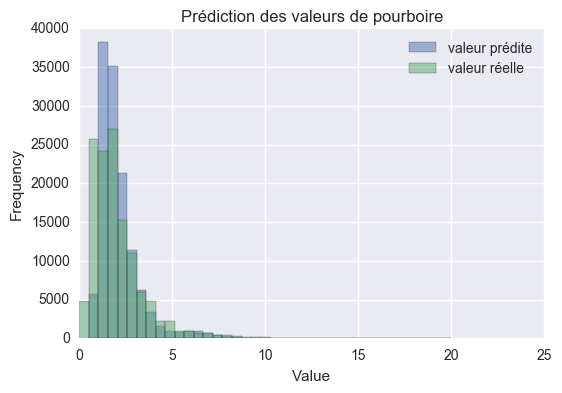

In [19]:
bins = numpy.linspace(0, 20, 40)

plt.hist(reg.predict(X_test), bins, alpha=0.5, label='valeur prédite')
plt.hist(y_test, bins, alpha=0.5, label='valeur réelle')
plt.legend(loc='upper right')
plt.title("Prédiction des valeurs de pourboire")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

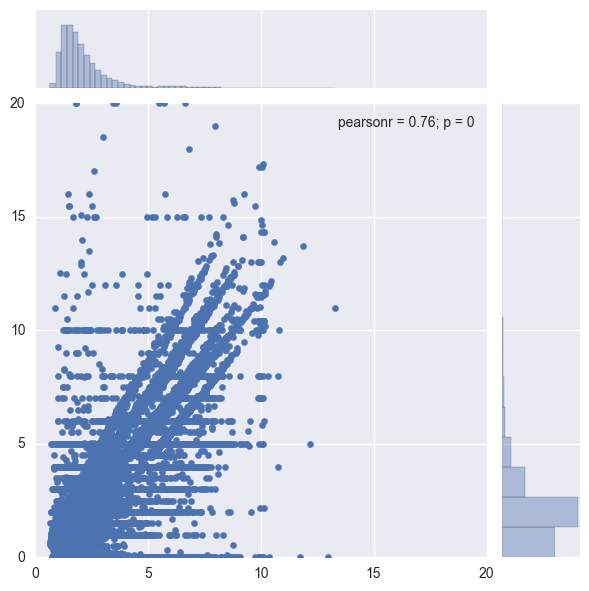

In [20]:
seaborn.jointplot(x=reg.predict(X_test), y=y_test.values, kind='scatter', xlim=(0,20), ylim=(0,20))

La régression fournit des résultats tout à fait corrects. Nous pouvons la confronter avec d'autres méthodes d'apprentissage.

### Nearest neighbours

In [21]:
from sklearn import neighbors
neigh = neighbors.KNeighborsRegressor()
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.50083116937908012

### Decision tree

In [22]:
from sklearn import tree
dtree = tree.DecisionTreeRegressor()
dtree.fit(X_train, y_train)
dtree.score(X_test, y_test)

0.13722633902593806

### Random forest

In [23]:
from sklearn import ensemble
forest = ensemble.RandomForestRegressor()
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.51804920397194509

### Gradient boosting

In [24]:
gboost = ensemble.GradientBoostingRegressor()
gboost.fit(X_train, y_train)
gboost.score(X_test, y_test)

0.57987651473361357

## Résultats et choix d'un modèle

In [25]:
synthese_algo = {
    'Linear_model': {'score_train': reg.score(X_train, y_train), 'score_test': reg.score(X_test, y_test)},
    'Nearest_neighbours': {'score_train': neigh.score(X_train, y_train), 'score_test': neigh.score(X_test, y_test)},
    'Decision_tree': {'score_train': dtree.score(X_train, y_train), 'score_test': dtree.score(X_test, y_test)},
    'Random_forest': {'score_train': forest.score(X_train, y_train), 'score_test': forest.score(X_test, y_test)},
    'Gradient_boosting': {'score_train': gboost.score(X_train, y_train), 'score_test': gboost.score(X_test, y_test)}
}

In [26]:
pandas.DataFrame(synthese_algo)

,Decision_tree,Gradient_boosting,Linear_model,Nearest_neighbours,Random_forest
score_test,0.137226,0.579877,0.577014,0.500831,0.518049
score_train,1.000000,0.567786,0.559268,0.653137,0.907883


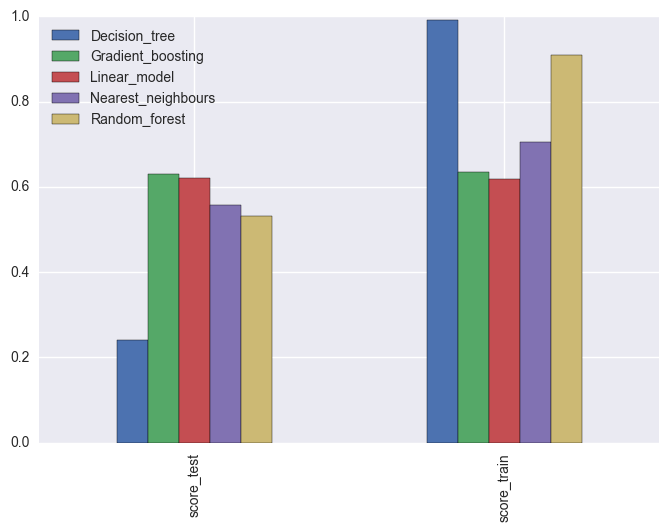

In [36]:
pandas.DataFrame(synthese_algo).plot.bar()

Pour conclure cette partie, affichons la learning_curve associée à chacun des algorithmes étudiés ici

ATTENTION : Cette section prend beaucoup de temps à calculer. Il vaut mieux accepter les résultats présentés et ne pas relancer ces cellules

(fonction 'plot_learning_curve' tirée de http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)

In [30]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=numpy.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = numpy.mean(train_scores, axis=1)
    train_scores_std = numpy.std(train_scores, axis=1)
    test_scores_mean = numpy.mean(test_scores, axis=1)
    test_scores_std = numpy.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Alexis\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

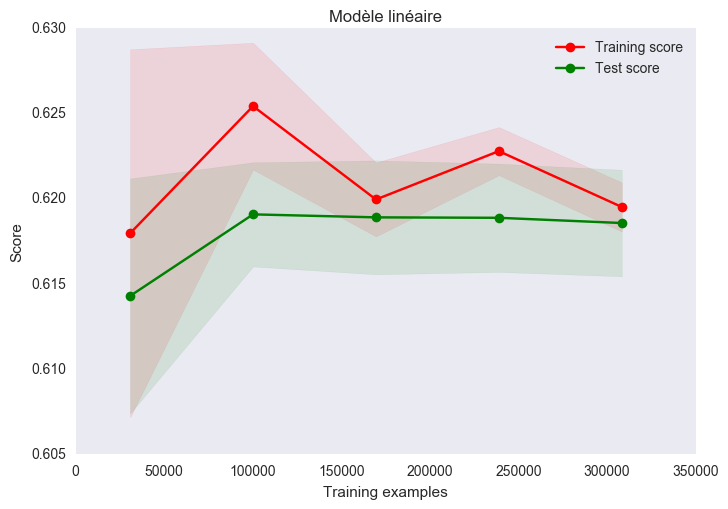

In [31]:
plot_learning_curve(linear_model.LinearRegression(), 'Modèle linéaire', X, y)

<module 'matplotlib.pyplot' from 'C:\\Users\\Alexis\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

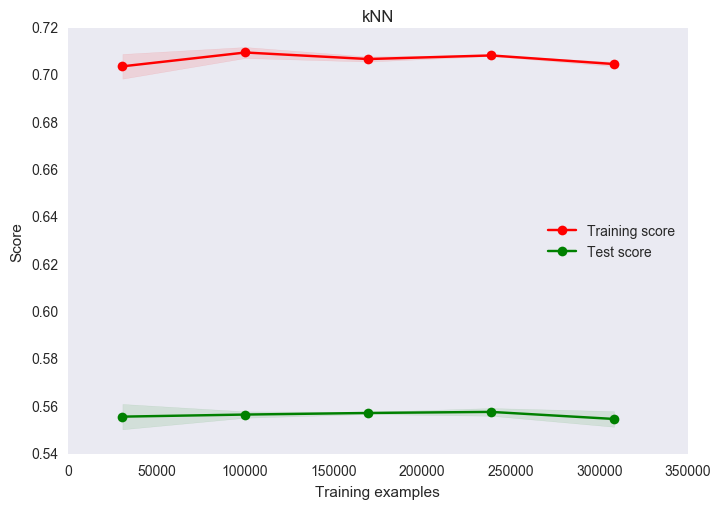

In [32]:
plot_learning_curve(neighbors.KNeighborsRegressor(), 'kNN', X, y)

<module 'matplotlib.pyplot' from 'C:\\Users\\Alexis\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

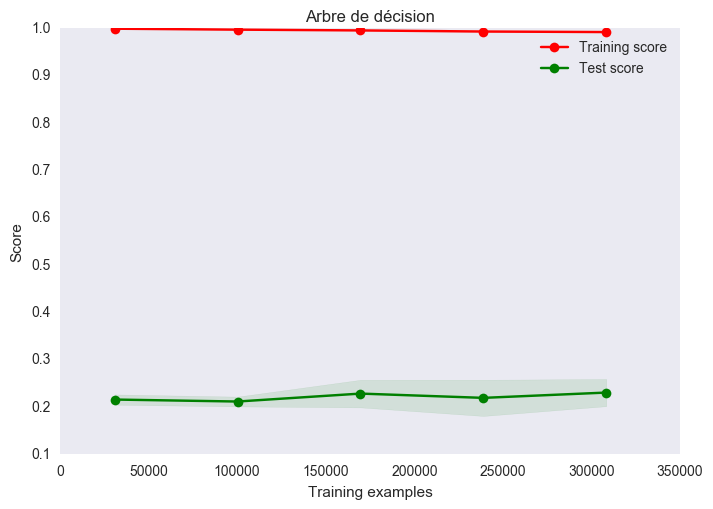

In [33]:
plot_learning_curve(tree.DecisionTreeRegressor(), 'Arbre de décision', X, y)

<module 'matplotlib.pyplot' from 'C:\\Users\\Alexis\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

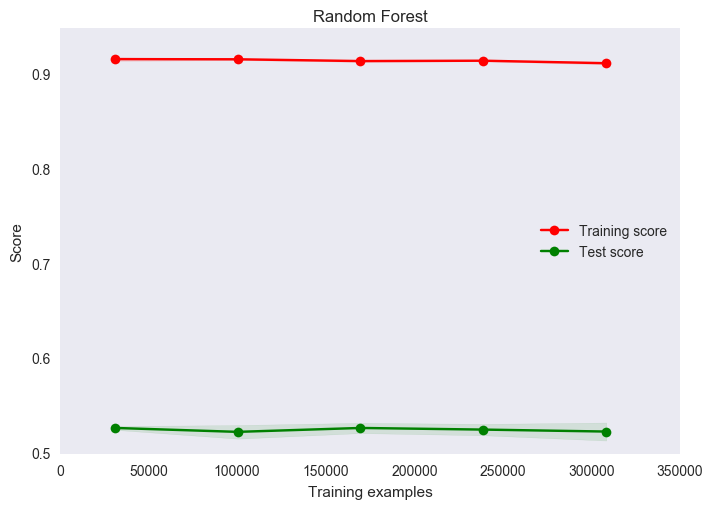

In [34]:
plot_learning_curve(ensemble.RandomForestRegressor(), 'Random Forest', X, y)

<module 'matplotlib.pyplot' from 'C:\\Users\\Alexis\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

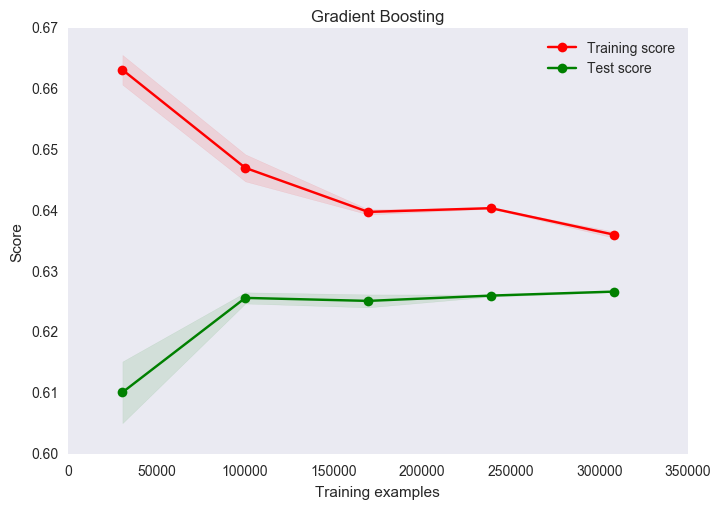

In [35]:
plot_learning_curve(ensemble.GradientBoostingRegressor(), 'Gradient Boosting', X, y)

**Conclusion** : les algorithmes kNN, arbre de décision et random forest ne sont pas adaptés à ce problème. En revanche le modèle linéaire et le gradient boosting obtiennent des scores de tests supérieurs et affichent de 'bonnes' learning curve.
La régression linéaire n'étant pas 'ajustable', on ne pourra l'améliorer plus. A l'inverse, la méthode de gradient boosting possède de nombreux hyperparamètres. C'est donc cette méthode que l'on se propose de fine tuner dans le prochain notebook.

Par rapport à la remarque en fin de notebook précedent, on a montré qu'il est possible de prédire correctement la valeur d'un pourboire, alors qu'il était impossible de prédire l'absence de pourboire dans le notebook précedent.